# Import Data and Train Model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as T
from transformers import get_scheduler, AdamW
from datasets import load_metric

import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
from scipy.fftpack import dct
import IPython.display
import librosa
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import mne
import mne.channels
from tqdm.auto import tqdm


c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data: Create Dataset


### Load Absence Seizure Data


In [2]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [3]:
%%capture
# Load the dataset
dataset = AbsenceDataset(
    "processed_data/absence/two_second_windows/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [4]:
dataset.x.shape

(8292, 5, 500)

# Split Data

70%, 20%, 10%


In [5]:
dataset_len = len(dataset)
dataset_len

8292

In [6]:
if (
    int(dataset_len * 0.7) + int(dataset_len * 0.2) + int(dataset_len * 0.1)
) != dataset_len:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(dataset_len * 0.7),
            int(dataset_len * 0.2),
            int(dataset_len * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            int(dataset_len * 0.1),
            int(dataset_len * 0.7),
            int(dataset_len * 0.2),
        ],
    )

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")
print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 5805
Eval Split: 1658
Test Split: 829
Total: 8292


In [7]:
train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
    train_set.indices
].shape

((5805, 5, 500), (5805,))

## Random Undersampling


In [8]:
bk, sz = 0, 0
for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 5555 // Absence Seizure: 250


In [9]:
shape = train_set.dataset.x[train_set.indices].shape
data_reshaped = train_set.dataset.x[train_set.indices]
data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))
data_reshaped.shape

(5805, 2500)

In [10]:
rand_us = RandomUnderSampler(random_state=42)
train_set_x, train_set_y = rand_us.fit_resample(
    data_reshaped, train_set.dataset.y[train_set.indices]
)

In [11]:
train_set_x = np.reshape(train_set_x, (train_set_x.shape[0], shape[1], shape[2]))
val_set_x = eval_set.dataset.x[eval_set.indices]
train_set_x.shape, val_set_x.shape

((500, 5, 500), (1658, 5, 500))

In [12]:
bk, sz = 0, 0
for i, v in enumerate(train_set_y):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 250 // Absence Seizure: 250


# STFT


Create STFT


In [13]:
n_fft = int(512 / 2)
window = "taylor"
hop_length = int(n_fft / 6)
fmin = 0
fmax = 5
n_mels = 7
sample_rate = 250

# Train
stft_channel_data = []
for i, channels in enumerate(train_set_x):
    stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
stft_channel_data = np.array(stft_channel_data)

# Val
val_stft_channel_data = []
for i, channels in enumerate(val_set_x):
    val_stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
val_stft_channel_data = np.array(val_stft_channel_data)

stft_channel_data.shape, val_stft_channel_data.shape

((500, 5, 7, 12), (1658, 5, 7, 12))

In [14]:
# Train
train_db = []
for i, channels in enumerate(stft_channel_data):
    train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
train_db = np.array(train_db)

# Val
val_db = []
for i, channels in enumerate(val_stft_channel_data):
    val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
val_db = np.array(val_db)

train_db.shape, val_db.shape

((500, 5, 7, 12), (1658, 5, 7, 12))

In [15]:
# Train
train_db_mean = []
for i, channels in enumerate(stft_channel_data):
    train_db_mean.append(np.mean(channels, axis=0))
train_db_mean = np.array(train_db_mean)

# Val
val_db_mean = []
for i, channels in enumerate(val_stft_channel_data):
    val_db_mean.append(np.mean(channels, axis=0))
val_db_mean = np.array(val_db_mean)

train_db_mean.shape, val_db_mean.shape

((500, 7, 12), (1658, 7, 12))

In [16]:
x = 312
print(train_set_y[x])

1


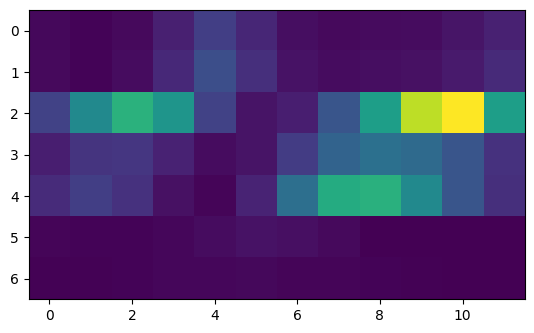

In [17]:
plt.imshow(train_db_mean[x])

Text(0.5, 1.0, 'Raw Channels')

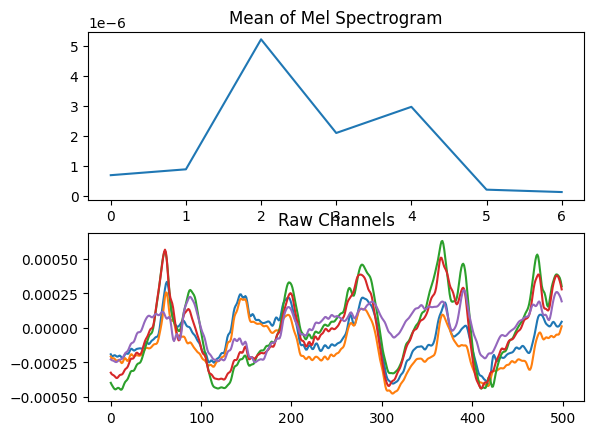

In [18]:
plt.subplot(2, 1, 1)
plt.plot(np.mean(train_db_mean[x], axis=1))
plt.title("Mean of Mel Spectrogram")
plt.subplot(2, 1, 2)
for i in train_set_x[x]:
    plt.plot(i)
plt.title("Raw Channels")

Convert STFT to Image for Input


In [19]:
from skimage import io
from sklearn import preprocessing

In [20]:
def sklearn_minnax(min, max, X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [21]:
train_input_x = []
for i, melspec in enumerate(train_db_mean):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    train_input_x.append(img.astype(np.uint8))
train_input_x = np.array(train_input_x)

val_input_x = []
for i, melspec in enumerate(val_db_mean):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    val_input_x.append(img.astype(np.uint8))
val_input_x = np.array(val_input_x)

# Remake Dataset


In [22]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [23]:
train_dataset = BalancedDataset(
    (train_input_x, train_set_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
eval_dataset = BalancedDataset(
    (val_input_x, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

In [24]:
# # Train
# train_db = []
# for i, channels in enumerate(stft_channel_data):
#     train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# train_db = np.array(train_db)

# # Val
# val_db = []
# for i, channels in enumerate(val_stft_channel_data):
#     val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# val_db = np.array(val_db)

# train_db.shape, val_db.shape

# DataLoaders


In [25]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=2,
    shuffle=True,
)
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=2, shuffle=True)

# Model

Mobilenet


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
from torchvision.models import mobilenet_v2

In [48]:
mobilenet_default = mobilenet_v2()


class ModelV2(nn.Module):
    def __init__(self, p_model):
        super(ModelV2, self).__init__()
        self.mobilenet_v2 = p_model
        self.AvgPool = nn.AvgPool2d(2)
        self.output = nn.Linear(1280, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, out):
        out = self.mobilenet_v2(out)
        out = self.AvgPool(out)
        out = self.output(out)
        out = self.softmax(out)
        return out


model = ModelV2(mobilenet_default).to(device)
model

ModelV2(
  (mobilenet_v2): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(

# Train


## Training Loop


### Print Inputs


In [29]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Train // Background: {bk} // Absence Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(eval_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Validation // Background: {bk} // Absence Seizure: {sz}")

Train // Background: 250 // Absence Seizure: 250
Validation // Background: 1596 // Absence Seizure: 62


### Training


In [30]:
for i, v in enumerate(eval_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label, type(first_input))
# print(first_input.squeeze())

for i, v in enumerate(train_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

# test_sample = test_sample.squeeze()
# test_sample = test_sample.numpy()
# print(test_sample.shape)
# io.imshow(test_sample)
# io.imsave("test_sample.png", test_sample.astype(np.uint8))

torch.Size([2, 3, 7, 12]) tensor([0., 0.]) <class 'torch.Tensor'>
torch.Size([2, 3, 7, 12]) tensor([1., 0.])


In [36]:
num_epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [105]:
# for batch in train_dataloader:
#         inputs, labels = batch
#         inputs, labels = inputs.to(device), labels.to(device)
#         plt.plot(inputs[0].cpu().numpy())
#         print(labels)
#         break

In [37]:
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))

loss_track = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(torch.int64)
        # inputs = inputs.squeeze()
        # print(inputs.shape, labels.shape)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()
        progress_bar.update(1)

        loss_track.append(loss)
    # break

print("Done")

100%|██████████| 25000/25000 [17:47<00:00, 23.42it/s]


Done


In [40]:
metric = load_metric("glue", "mrpc")
model.eval()
tp, fp, tn, fn = 0, 0, 0, 0
results_list = []
for batch in eval_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)

    results_list.append(outputs)

    # if outputs > 0.5:
    #     if labels == 1:
    #         tp += 1
    #     else:
    #         fp += 1
    # else:
    #     if labels == 0:
    #         tn += 1
    #     else:
    #         fn += 1

    # logits = outputs.logits
    # predictions = torch.argmax(logits, dim=-1)
    # metric.add_batch(predictions=outputs, references=labels)

# results = metric.compute()
# for i, v in enumerate(eval_dataloader):
#     if v[1].squeeze() == torch.tensor([1.0]):
#         print(results_list[i])

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [44]:
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(results_list[0])

True Positives: 0
False Positives: 0
True Negatives: 0
False Negatives: 0
tensor([[0.0009, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
        [0.0009, 0.0006, 0.0007,  ..., 0.0006, 0.0006, 0.0006]],
       device='cuda:0')


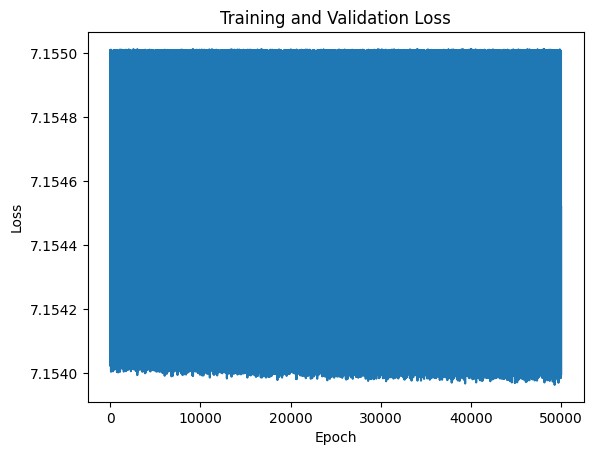

In [38]:
# Plot losses
a = []
for i in range(len(loss_track)):
    a.append(loss_track[i].item())

plt.plot(range(len(a)), a, label="Training Loss")
# plt.plot(range(len(loss_track_valid)), loss_track_valid, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [115]:
print(loss_track[4])

tensor(-0., device='cuda:0', grad_fn=<DivBackward1>)
